# Roberta


Fine-tune a Bert model to classify sentiment.

Implementation notes: Roberta init bug:

- https://github.com/huggingface/transformers/issues/5421
- https://github.com/huggingface/transformers/issues/9882

----
```
: 25.05.24
: Zach Wolpe
: zachcolinwolpe@gmail.com
```
---

In [22]:
# importing neccessary libraries 
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, BertPreTrainedModel, BertModel,AdamW
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd 
import numpy as np
import torch
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
import sklearn


from nltk.corpus import stopwords
import argparse
import logging
import string
import re
import os

from sklearn.model_selection import train_test_split, KFold
import torch.optim as optim
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import BertModel
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zachwolpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
from Roberta_classifier import (RobertaWithActivationAndRegularization, RoBertaTokenizer)
from ML_training_code import (generate_K_Fold_data, torch_tensorize, plot_training_validation, training_loop)

---
## Config
---

In [24]:
# Config ---------------------------------------->>
PATH_TO_DATA = '../data/train_test/'
SAVE_LOC = '../model-artifacts/'
BATCH_SIZE = 10
DEBUG_MODE = True
EPOCHS = 1
CROSS_VALIDATION = False
K_FOLDS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Config ---------------------------------------->>

# Load data
X_train = pd.read_csv(PATH_TO_DATA + 'X_train.csv')
y_train = pd.read_csv(PATH_TO_DATA + 'y_train.csv')
X_test = pd.read_csv(PATH_TO_DATA + 'X_test.csv')
y_test = pd.read_csv(PATH_TO_DATA + 'y_test.csv')


# Downsample for testing
if DEBUG_MODE:
    X_train = X_train[:10]
    y_train = y_train[:10]


---
## Instantiate RoBerto
---

In [25]:
# Specify the pretrained BERT model name
model_name = 'roberta-base'

# Create an instance of the model
model = RobertaWithActivationAndRegularization(pretrained_model_name='roberta-base', num_labels=3)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaWithActivationAndRegularization(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
       

----
## Training Runtime Hyperparameters
----

In [26]:
# Define the optimizer and criterion
learning_rate = 2e-06
weight_decay = 0.0001  
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

---
## Run without K-Fold Cross Validation
----

In [27]:
# Generate 1 fold
if not CROSS_VALIDATION:
    gkfd = generate_K_Fold_data(X_train, y_train, num_splits=K_FOLDS)
    X_train_fold, y_train_fold, X_val_fold, y_val_fold, train_index, val_index = next(gkfd)

---
## Tokenize
---

In [28]:
if not CROSS_VALIDATION:
    input_ids_train, attention_masks_train, y_train = RoBertaTokenizer(X_train_fold, y_train_fold)
    input_ids_val, attention_masks_val, y_val = RoBertaTokenizer(X_val_fold, y_val_fold)


---
## Torch Tensors
---

In [29]:
if not CROSS_VALIDATION:
        (train_dataloader,
        train_dataloader,
        val_dataset,
        val_dataloader) = torch_tensorize(input_ids_train,
                attention_masks_train,
                y_train_fold,
                input_ids_val,
                attention_masks_val,
                y_val_fold,
                BATCH_SIZE=BATCH_SIZE)

---
## Training Loop
---

In [30]:
if not CROSS_VALIDATION:
    # Training loop
    train_losses_fold, valid_losses_fold, accuracies_fold = training_loop(model,
        optimizer,
        criterion,
        train_dataloader,
        val_dataloader,
        device,
        epochs=EPOCHS)


Training the model...
Epoch 1/1 - Training Loss: 1.0935 - Validation Loss: 1.1678 - Training Accuracy: 0.3750 - Validation Accuracy: 0.0000
Finished Training.


---
## Plot training and validation loss
---

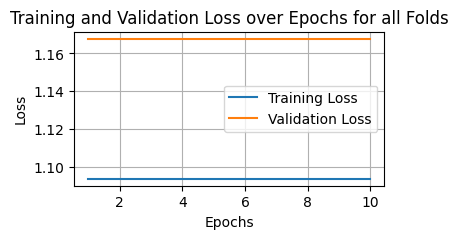

In [35]:
if not CROSS_VALIDATION:
    plot_training_validation(train_losses_fold, valid_losses_fold)

---
## K-Fold Cross-Validation
---

In [32]:
if CROSS_VALIDATION:
    
    # Build generator
    gkfd = generate_K_Fold_data(X_train, y_train, num_splits=K_FOLDS)
    
    results = []
    for i, _gkfd in enumerate(gkfd):
        print(f'Fold {i+1}/{K_FOLDS}')
        X_train_fold, y_train_fold, X_val_fold, y_val_fold, train_index, val_index = _gkfd

        # Tokenize
        input_ids_train, attention_masks_train, y_train = RoBertaTokenizer(X_train_fold, y_train_fold)
        input_ids_val, attention_masks_val, y_val = RoBertaTokenizer(X_val_fold, y_val_fold)


        # Create Torch Tensors
        (train_dataloader,
        train_dataloader,
        val_dataset,
        val_dataloader) = torch_tensorize(input_ids_train,
                attention_masks_train,
                y_train_fold,
                input_ids_val,
                attention_masks_val,
                y_val_fold,
                BATCH_SIZE=BATCH_SIZE)

        # Define lists to store metrics for each fold
        train_losses_per_fold = []
        valid_losses_per_fold = []
        accuracies_per_fold = []

        # Training loop
        train_losses_fold, valid_losses_fold, accuracies_fold = training_loop(model,
            optimizer,
            criterion,
            train_dataloader,
            val_dataloader,
            device,
            epochs=EPOCHS)
        
        # Save metrics for this fold
        train_losses_per_fold.append(train_losses_fold)
        valid_losses_per_fold.append(valid_losses_fold)
        accuracies_per_fold.append(accuracies_fold)

        # save results
        results.append({
            'train_losses': train_losses_fold,
            'valid_losses': valid_losses_fold,
            'accuracies': accuracies_fold
        })

---
## Save Model
---

In [33]:
# Save Bert Model
if not DEBUG_MODE:
    torch.save(model.state_dict(), f'{SAVE_LOC}robert_model.pth')
